In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from ddop.datasets import load_yaz
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
path = Path("..")
path_ds = path/'datasets'
path_res = path/'res_data'
path_plot = path/'plots'

In [3]:
res = []

products = ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']
#products = [products]
df = load_yaz(encode_date_features=True, include_prod=products).frame
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
data = torch.tensor(df_scaled, dtype=torch.float32)
n_prod = len(products)
N = data.shape[0]

# make train/val/test
#n_train = int(0.8 * N)
n_train = 600 #
#n_train = int(1 * N)
train_x, train_y = data[:n_train, :-n_prod], data[:n_train, -n_prod:]
test_x, test_y = data[n_train:, :-n_prod], data[n_train:, -n_prod:]

# make continguous
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:0')

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

# initialize likelihood and model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_prod).cuda()

model = MultitaskGPModel(train_x, train_y, likelihood, n_prod).cuda()

gpytorch.settings.cg_tolerance(3)

# Find optimal model hyperparameters
model.train()
likelihood.train()
training_iter=80

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.base_kernel.lengthscale.item(),
    #    model.likelihood.noise.item()
    #))
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    #observed_pred_train = likelihood(model(train_x))

y_train_unscaled = scaler.inverse_transform(df_scaled[:n_train,:])[:,-n_prod:]
y_test_unscaled = scaler.inverse_transform(df_scaled[n_train:,:])[:,-n_prod:]

n_features = df_scaled.shape[1]
nv_means = observed_pred.mean.cpu().numpy()

#nv_means = observed_pred_train.mean.cpu().numpy()
nv_means_unscaled = scaler.inverse_transform(np.concatenate((np.stack([nv_means[:,0] for i in range(n_features-n_prod)], axis=1), nv_means), axis=1))[:,-n_prod:]

four_sigma = observed_pred.confidence_region()[1]-observed_pred.confidence_region()[0]
nv_sigma = four_sigma.cpu().detach().numpy()/4.
nv_sigma_unscaled = scaler.inverse_transform(np.concatenate((np.stack([nv_sigma[:,0] for i in range(n_features-n_prod)], axis=1), nv_sigma), axis=1))[:,-n_prod:]


for i, target in enumerate(df.columns[-n_prod:].tolist()):

    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        nv_quantile = np.quantile(y_train_unscaled[:,i], q=cu/(cu+co))
        nv_solution = nv_means_unscaled[:,i]+norm.ppf(cu/(cu+co))*nv_sigma_unscaled[:,i]
        cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled[:,i]])
        cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled[:,i])])
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_saa, "type":"saa", "target": target})
        res.append(ser_tmp)
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_gp, "type":"gp", "target": target})
        res.append(ser_tmp)
df_res = pd.DataFrame(res)

Planning to run on 1 GPUs.
Iter 1/80 - Loss: 762.019
Iter 2/80 - Loss: 732.885
Iter 3/80 - Loss: 701.777
Iter 4/80 - Loss: 673.013
Iter 5/80 - Loss: 644.040
Iter 6/80 - Loss: 613.654
Iter 7/80 - Loss: 581.403
Iter 8/80 - Loss: 552.199
Iter 9/80 - Loss: 520.888
Iter 10/80 - Loss: 491.704
Iter 11/80 - Loss: 460.696
Iter 12/80 - Loss: 432.164
Iter 13/80 - Loss: 404.393
Iter 14/80 - Loss: 375.612
Iter 15/80 - Loss: 347.456
Iter 16/80 - Loss: 318.075
Iter 17/80 - Loss: 290.175
Iter 18/80 - Loss: 260.132
Iter 19/80 - Loss: 232.836
Iter 20/80 - Loss: 201.893
Iter 21/80 - Loss: 172.627
Iter 22/80 - Loss: 142.827
Iter 23/80 - Loss: 113.444
Iter 24/80 - Loss: 85.000
Iter 25/80 - Loss: 55.871
Iter 26/80 - Loss: 27.805
Iter 27/80 - Loss: -0.807
Iter 28/80 - Loss: -29.392
Iter 29/80 - Loss: -57.305
Iter 30/80 - Loss: -82.274
Iter 31/80 - Loss: -110.028
Iter 32/80 - Loss: -136.457
Iter 33/80 - Loss: -161.900
Iter 34/80 - Loss: -189.186
Iter 35/80 - Loss: -212.541
Iter 36/80 - Loss: -236.322
Iter 37/

nnn= 'SOF_results_Symmetric.csv'
df_tmp = pd.read_csv(nnn)
#df_tmp = df_tmp.drop(columns=["Unnamed: 0"])
df_tmp['target']="STEAK"
df_tmp.to_csv(nnn, index=False)

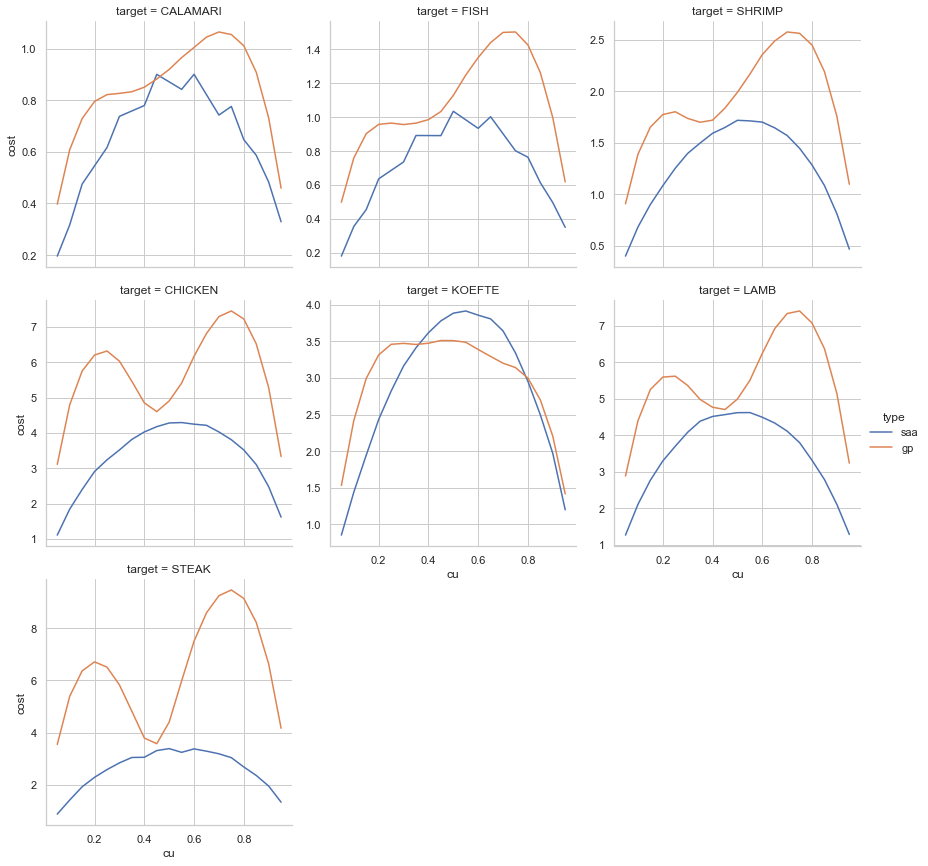

In [4]:
df_plot = df_res
#df_plot = pd.read_csv('res_data/gp_all-paste.csv')
df_plot = df_plot[~(df_plot.type.isin(["rf_rf", "rf_grf", "rf_oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["rf_approx_risk", "rf_approx_sol", "oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["saa", "rf"]))]
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",col_wrap=3,facet_kws={'sharey':False},
    col="target", hue="type",kind="line", aspect=1, height=4); 

## Plot Space

In [5]:
f0 = [torch.linspace(0, 1, 200) for i in range(1)]
fx = torch.linspace(1,1, 200) #temp
fn = [torch.linspace(0, 1, 200) for i in range(5)]#[torch.linspace(0.5, 0.5, 200) for i in range(2)]


In [6]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    sample_x = torch.stack([*f0,fx,*fn] , axis=-1).cuda()
    observed_pred = likelihood(model(sample_x))

RuntimeError: Sizes of tensors must match except in dimension 1. Got 7 and 29 (The offending index is 0)

In [ ]:
feature_idx=2
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(train_x[:,feature_idx].cpu().numpy(), train_y.cpu().numpy(), 'k*')
    #ax.plot(sample_x[:,feature_idx].cpu().numpy(), y_samples.cpu().numpy(), lw=1)
    # Plot predictive means as blue line
    ax.plot(fx.numpy(), observed_pred.mean.cpu().numpy(), 'b')
    ax.plot(sample_x[:,feature_idx].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])